# 코드 자료 출처: https://github.com/utkuozbulak/pytorch-cnn-visualizations

# 수강생분의 이름, 학번을 반영해주세요.

In [2]:
id = '20197132'
name = '주준하'
print(id, name)

20197132 주준하


구글 드라이브 연동

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


실습, 샘플이미지 폴더 경로 설정

In [ ]:
!ls /gdrive/My\ Drive/Colab\ Notebooks/CV_과제9/pytorch-cnn-visualizations-master

input_images  LICENSE  README.md  results  src


In [4]:
import os
import glob
import sys

workspace_path = '/gdrive/My Drive/Colab Notebooks/CV_과제9'  # 실습파일 저장 경로 설정
visualization_path = os.path.join(workspace_path, 'pytorch-cnn-visualizations-master')  # 시각화 코드파일 경로 설정

이미지 처리 함수 정의

In [18]:
"""
Created on Thu Oct 21 11:09:09 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import copy
import numpy as np
from PIL import Image
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_dir, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_dir (str): Directory path to the exported image
        file_name (str): File name to be exported
    """
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join(file_dir, file_name + '.png')
    save_image(gradient, path_to_file)
    plot_image(gradient)


def save_class_activation_images(org_img, activation_map, file_dir, file_name):
    """
        Saves cam activation map and activation map on the original image

    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_dir (str): Directory path to the exported image
        file_name (str): File name of the exported image
    """
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join(file_dir, file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    plot_image(heatmap)
    # Save colored heatmap on image
    path_to_file = os.path.join(file_dir, file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    plot_image(heatmap_on_image)
    # Save grayscale heatmap
    path_to_file = os.path.join(file_dir, file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)
    plot_image(activation_map)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial

        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def plot_image(im):
    """
        Plots a numpy matrix or PIL image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    plt.imshow(im)
    plt.show()


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize

    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = ((os.path.join(visualization_path, 'input_images/img10.jpg'), 671),
                    (os.path.join(visualization_path, 'input_images/img13.jpg'), 817),
                    (os.path.join(visualization_path, 'input_images/img16.jpg'), 510),
                    (os.path.join(visualization_path, 'input_images/tinca-tinca.jpg'), 0),
                    (os.path.join(visualization_path, 'input_images/Carassius auratus.jpg'), 1),
                    (os.path.join(visualization_path, 'input_images/great white shark.jpg'), 2),
                    (os.path.join(visualization_path, 'input_images/electric ray.jpg'), 5),
                    (os.path.join(visualization_path, 'input_images/hen.jpg'), 8),
                    (os.path.join(visualization_path, 'input_images/brambling.jpg'), 10),
                    (os.path.join(visualization_path, 'input_images/house finch.jpg'), 12),
                    (os.path.join(visualization_path, 'input_images/house finch.jpg'), 12),
                    (os.path.join(visualization_path, 'input_images/junco.jpg'), 13),
                    (os.path.join(visualization_path, 'input_images/indigo bunting.jpg'), 14),
                    (os.path.join(visualization_path, 'input_images/robin.jpg'), 15),
                    (os.path.join(visualization_path, 'input_images/bulbul.jpg'), 16),
                    (os.path.join(visualization_path, 'input_images/magpie.jpg'), 16),
                    (os.path.join(visualization_path, 'input_images/chickadee.jpg'), 19),
                    (os.path.join(visualization_path, 'input_images/water ouzel.jpg'), 20),
                    (os.path.join(visualization_path, 'input_images/kite.jpg'), 20),
                    (os.path.join(visualization_path, 'input_images/bald eagle.jpg'), 21),
                    (os.path.join(visualization_path, 'input_images/great grey owl.jpg'), 24),
                    )
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    print(original_image.size)
    original_image = original_image.resize((224, 224))
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model (use alexnet)
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

CNN Layer Visualization

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Iteration: 1 Loss: 1.24
Iteration: 2 Loss: -1.74
Iteration: 3 Loss: -8.17
Iteration: 4 Loss: -15.17
Iteration: 5 Loss: -21.88


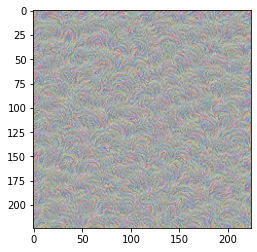

Iteration: 6 Loss: -28.16
Iteration: 7 Loss: -34.12
Iteration: 8 Loss: -39.77
Iteration: 9 Loss: -45.29
Iteration: 10 Loss: -50.60


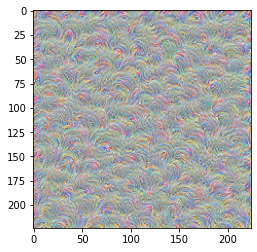

Iteration: 11 Loss: -55.83
Iteration: 12 Loss: -60.96
Iteration: 13 Loss: -66.02
Iteration: 14 Loss: -71.04
Iteration: 15 Loss: -75.99


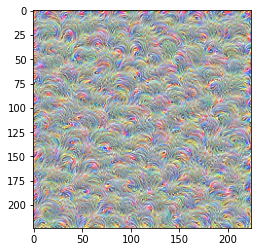

Iteration: 16 Loss: -80.91
Iteration: 17 Loss: -85.83
Iteration: 18 Loss: -90.73
Iteration: 19 Loss: -95.61
Iteration: 20 Loss: -100.50


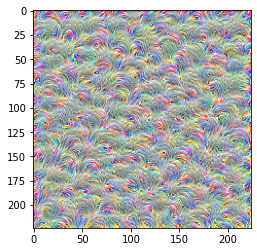

Iteration: 21 Loss: -105.41
Iteration: 22 Loss: -110.33
Iteration: 23 Loss: -115.25
Iteration: 24 Loss: -120.19
Iteration: 25 Loss: -125.14


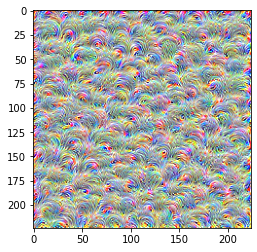

Iteration: 26 Loss: -130.12
Iteration: 27 Loss: -135.10
Iteration: 28 Loss: -140.10
Iteration: 29 Loss: -145.14
Iteration: 30 Loss: -150.21


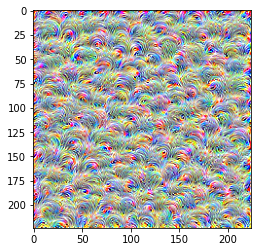

In [6]:
"""
Created on Sat Nov 18 23:12:08 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models

cnn_layer_vis_path = os.path.join(workspace_path, 'results/cnn_layer_vis')  # 시각화 결과물 경로 설정


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists(cnn_layer_vis_path):
            os.makedirs(cnn_layer_vis_path)

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save & Plot image
            if i % 5 == 0:
                im_path = os.path.join(cnn_layer_vis_path, 'layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg')
                save_image(self.created_image, im_path)
                plot_image(self.created_image)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save & Plot image
            if i % 5 == 0:
                im_path = os.path.join(cnn_layer_vis_path, 'layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg')
                save_image(self.created_image, im_path)
                plot_image(self.created_image)


if __name__ == '__main__':
    cnn_layer = 17
    filter_pos = 5
    # Fully connected layer is not needed
    pretrained_model = models.vgg16(pretrained=True).features
    layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

    # Layer visualization with pytorch hooks
    layer_vis.visualise_layer_with_hooks()

    # Layer visualization without pytorch hooks
    # layer_vis.visualise_layer_without_hooks()


Grad CAM

(500, 367)
torch.Size([1, 9216])





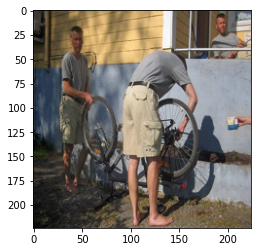

Original image: img10


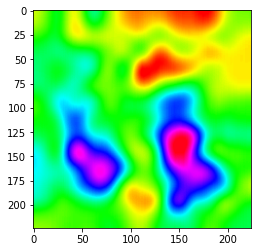

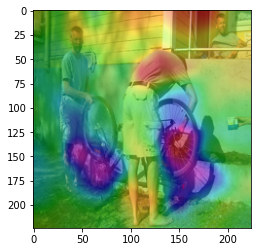

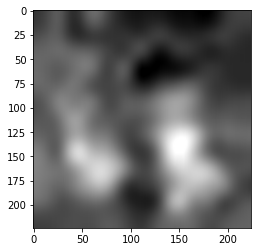

Grad cam completed: img10
(500, 375)
torch.Size([1, 9216])





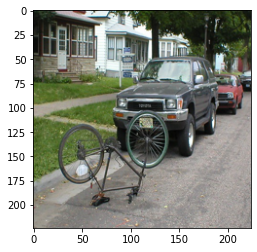

Original image: img13


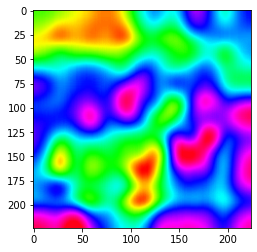

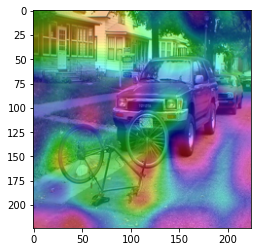

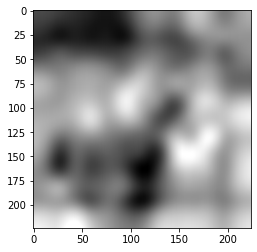

Grad cam completed: img13
(500, 332)
torch.Size([1, 9216])





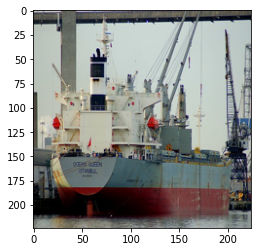

Original image: img16


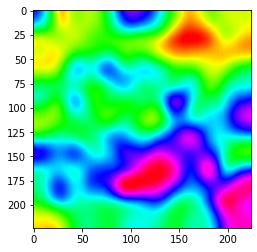

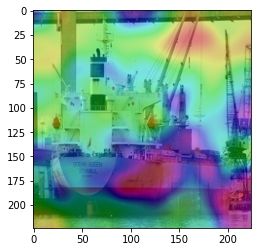

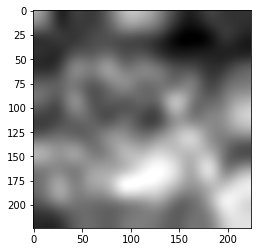

Grad cam completed: img16


In [19]:
"""
Created on Thu Oct 26 11:06:51 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
from PIL import Image
import numpy as np
import torch

grad_cam_vis_path = os.path.join(workspace_path, 'results/grad_cam_vis')  # 시각화 결과물 경로 설정


class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        print(x.size())
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.numpy()[0]
        # Get convolution outputs
        target = conv_output.data.numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Have a look at issue #11 to check why the above is np.ones and not np.zeros
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam


if __name__ == '__main__':
    for target_example in range(3):
        # Get params
        (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
            get_example_params(target_example)
        # Define model (use alexnet)
        pretrained_model = models.alexnet(pretrained=True)
        # Grad cam
        grad_cam = GradCam(pretrained_model, target_layer=11)
        # Generate cam mask
        cam = grad_cam.generate_cam(prep_img, target_class)
        # Save mask
        print('\n\n')
        plot_image(original_image)
        print(f'Original image: {file_name_to_export}')
        save_class_activation_images(original_image, cam, grad_cam_vis_path, file_name_to_export)
        print(f'Grad cam completed: {file_name_to_export}')

Guided Backpropagation

(500, 367)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


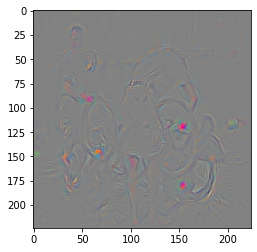

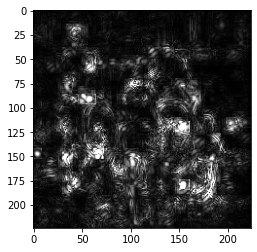

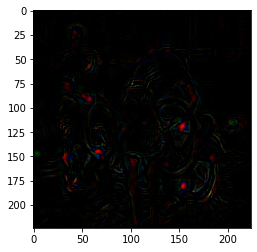

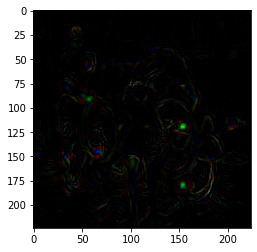

Guided backprop completed: img10
(500, 375)


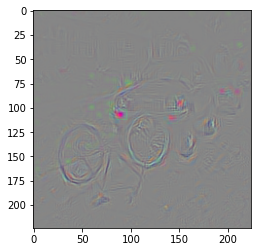

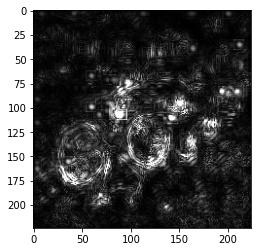

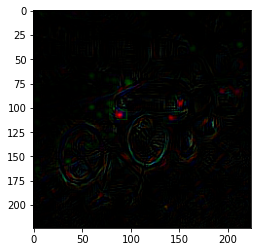

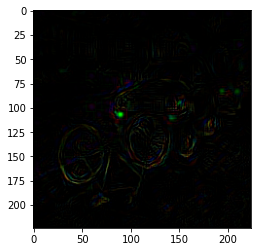

Guided backprop completed: img13
(500, 332)


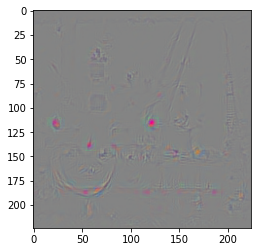

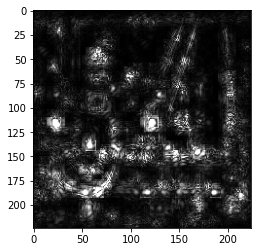

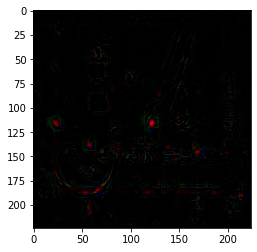

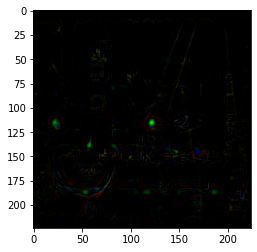

Guided backprop completed: img16


In [20]:
"""
Created on Thu Oct 26 11:23:47 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import torch
from torch.nn import ReLU

guided_backprop_vis_path = os.path.join(workspace_path, 'results/guided_backprop_vis')  # 시각화 결과물 경로 설정


class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    for target_example in range(3):
        (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
            get_example_params(target_example)

        # Guided backprop
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, target_class)
        # Save colored gradients
        save_gradient_images(guided_grads, guided_backprop_vis_path, file_name_to_export + '_Guided_BP_color')
        # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        # Save grayscale gradients
        save_gradient_images(grayscale_guided_grads, guided_backprop_vis_path, file_name_to_export + '_Guided_BP_gray')
        # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        save_gradient_images(pos_sal, guided_backprop_vis_path, file_name_to_export + '_pos_sal')
        save_gradient_images(neg_sal, guided_backprop_vis_path, file_name_to_export + '_neg_sal')
        print(f'Guided backprop completed: {file_name_to_export}')

Guided Grad CAM

(500, 367)
torch.Size([1, 9216])
Grad cam completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Guided backpropagation completed


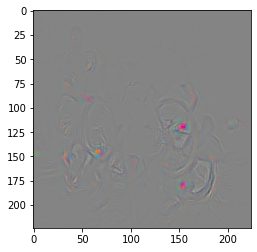

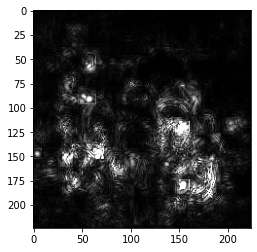

Guided grad cam completed
(500, 375)
torch.Size([1, 9216])
Grad cam completed
Guided backpropagation completed


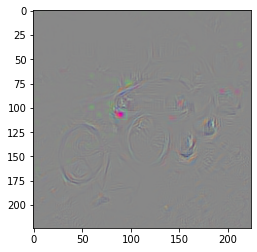

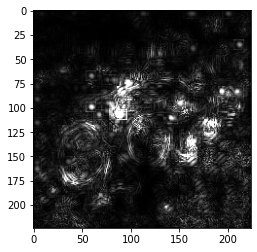

Guided grad cam completed
(500, 332)
torch.Size([1, 9216])
Grad cam completed
Guided backpropagation completed


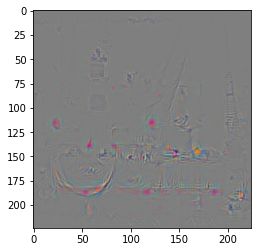

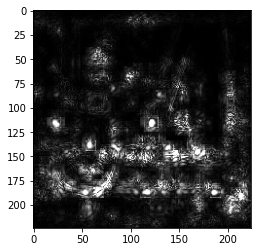

Guided grad cam completed


In [21]:
"""
Created on Thu Oct 23 11:27:15 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import numpy as np

guided_grad_cam_vis_path = os.path.join(workspace_path, 'results/guided_grad_cam_vis')  # 시각화 결과물 경로 설정


def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb


if __name__ == '__main__':
    for target_example in range(3):
        # Get params
        (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
            get_example_params(target_example)

        # Grad cam
        gcv2 = GradCam(pretrained_model, target_layer=11)
        # Generate cam mask
        cam = gcv2.generate_cam(prep_img, target_class)
        print('Grad cam completed')

        # Guided backprop
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, target_class)
        print('Guided backpropagation completed')

        # Guided Grad cam
        cam_gb = guided_grad_cam(cam, guided_grads)
        save_gradient_images(cam_gb, guided_grad_cam_vis_path, file_name_to_export + '_GGrad_Cam')
        grayscale_cam_gb = convert_to_grayscale(cam_gb)
        save_gradient_images(grayscale_cam_gb, guided_grad_cam_vis_path, file_name_to_export + '_GGrad_Cam_gray')
        print('Guided grad cam completed')


# 실습과제

## Kaggle 에서 open dataset 다운로드 받아서 시각화 결과 출력하고 분석하기
- ImageNet 데이터셋 클래스에 있는 객체에 대해서 open dataset 다운로드하기
 - ImageNet 데이터셋 클래스(1000 종류) 목록: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
- 데이터셋에 포함된 이미지가 너무 많다면 랜덤하게 20장만 선별하기
* 유의사항: 데이터셋을 구글드라이브에 업로드한 이후에 구글드라이브 마운트하기 (파일 업로드 이후에 마운트해야 파일 접근 가능)

구글 드라이브 다시 마운트

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


실습문제 1. Grad CAM 시각화 (예제 코드 수정)

In [22]:

for target_example in range(20):
    # Get params
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
    # Define model (use alexnet)
    pretrained_model = models.alexnet(pretrained=True)
        # Grad cam
    grad_cam = GradCam(pretrained_model, target_layer=11)
        # Generate cam mask
    cam = grad_cam.generate_cam(prep_img, target_class)
        # Save mask
    print('\n\n')
    plot_image(original_image)
    print(f'Original image: {file_name_to_export}')
    save_class_activation_images(original_image, cam, grad_cam_vis_path, file_name_to_export)
    print(f'Grad cam completed: {file_name_to_export}')

Output hidden; open in https://colab.research.google.com to view.

실습문제 2. Guided Backpropagation 시각화 및 결과 분석하기 (예제 코드 수정)

In [24]:
"""
Created on Thu Oct 26 11:23:47 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import torch
from torch.nn import ReLU

guided_backprop_vis_path = os.path.join(workspace_path, 'results/guided_backprop_vis')  # 시각화 결과물 경로 설정


class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    for target_example in range(20):
        (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
            get_example_params(target_example)

        # Guided backprop
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, target_class)
        # Save colored gradients
        save_gradient_images(guided_grads, guided_backprop_vis_path, file_name_to_export + '_Guided_BP_color')
        # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        # Save grayscale gradients
        save_gradient_images(grayscale_guided_grads, guided_backprop_vis_path, file_name_to_export + '_Guided_BP_gray')
        # Positive and negative saliency maps
        pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        save_gradient_images(pos_sal, guided_backprop_vis_path, file_name_to_export + '_pos_sal')
        save_gradient_images(neg_sal, guided_backprop_vis_path, file_name_to_export + '_neg_sal')
        print(f'Guided backprop completed: {file_name_to_export}')

Output hidden; open in https://colab.research.google.com to view.

실습문제 3. Guided Grad CAM 시각화 및 결과 분석하기 (예제 코드 수정)

In [25]:
"""
Created on Thu Oct 23 11:27:15 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import numpy as np

guided_grad_cam_vis_path = os.path.join(workspace_path, 'results/guided_grad_cam_vis')  # 시각화 결과물 경로 설정


def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb


if __name__ == '__main__':
    for target_example in range(20):
        # Get params
        (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
            get_example_params(target_example)

        # Grad cam
        gcv2 = GradCam(pretrained_model, target_layer=11)
        # Generate cam mask
        cam = gcv2.generate_cam(prep_img, target_class)
        print('Grad cam completed')

        # Guided backprop
        GBP = GuidedBackprop(pretrained_model)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, target_class)
        print('Guided backpropagation completed')

        # Guided Grad cam
        cam_gb = guided_grad_cam(cam, guided_grads)
        save_gradient_images(cam_gb, guided_grad_cam_vis_path, file_name_to_export + '_GGrad_Cam')
        grayscale_cam_gb = convert_to_grayscale(cam_gb)
        save_gradient_images(grayscale_cam_gb, guided_grad_cam_vis_path, file_name_to_export + '_GGrad_Cam_gray')
        print('Guided grad cam completed')


Output hidden; open in https://colab.research.google.com to view.

실습문제 4. 시각화 결과 분석하기 (어떤 경우에 시각화 결과가 우수/미흡한지? CNN 모델이 객체의 어느 부분을 중점적으로 보는지? 등): 

배경색이 초록색 계열인 경우 객채의 시각화가 잘되지 않음